In [1]:
import time
import numpy as np
import scipy
from scipy import ndimage
import sklearn
from sklearn import preprocessing

from keras.layers import Dense, Input
from keras.models import Model
from keras import optimizers

from PIL import Image


Using TensorFlow backend.


In [2]:
def resize(im,percent):
    """ retaille suivant un pourcentage 'percent' """
    w,h = im.size
    return im.resize(((percent*w)/100,(percent*h)/100))

def resize2(im,pixels):
    """ retaille le cotÃ© le plus long en 'pixels'
        (pour tenir dans une frame de pixels x pixels)
    """
    (wx,wy) = im.size
    rx=1.0*wx/pixels
    ry=1.0*wy/pixels
    if rx>ry:
        rr=rx
    else:
        rr=ry
    return im.resize((int(wx/rr), int(wy/rr)))
 


In [3]:
img = Image.open("lena512.jpg") # image extension *.png,*.jpg
new_width  = 32
new_height = 32
compressed = img.resize((new_width, new_height), Image.ANTIALIAS)
compressed.save("lena32.jpg") # format may what u want ,*.png,*jpg,*.gif
 

In [4]:
compressed = img.resize((16, 16), Image.ANTIALIAS)
compressed.save("lena16.jpg")

# Opening compressed, enlarging and saving enlarged for NN input
input_image_source = Image.open("lena16.jpg")
new_width  = 32
new_height = 32
enlarged = input_image_source.resize((new_width, new_height), Image.ANTIALIAS)
enlarged.show()
enlarged.save("lena32_enlarged.jpg")


![lena512](lena512.jpg)
![lena32](lena32.jpg)
![lena16](lena16.jpg)



In [5]:
# everything up til here is from pastebin
# normalize (use sklearn instead of vanilla numpy)

# Raw enlarged image used for NN input
input_image = ndimage.imread("lena32_enlarged.jpg").astype(float)
input_image = input_image.reshape((32*32,1))
min_max_scaler = preprocessing.MinMaxScaler()
input_image = min_max_scaler.fit_transform(input_image)
#print(input_image)
#print(np.average(input_image))
#print(np.std(input_image))
#print(np.min(input_image))
#print(np.max(input_image))
#print(scipy.stats.describe(input_image))

# Raw image original used for NN output
output_image = ndimage.imread("lena32.jpg").astype(float)
output_image = output_image.reshape((32*32,1))
output_image = min_max_scaler.fit_transform(output_image)

input_rows, input_cols = input_image.shape

#print(output_image)
#print(np.average(output_image))
#print(np.std(output_image))
#print(np.min(output_image))
#print(np.max(output_image))
#print(scipy.stats.describe(output_image))


In [7]:
# function to instantiate neural network
# see https://keras.io/getting-started/sequential-model-guide/
import keras
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from keras.regularizers import l1

def create_model(num_components=input_cols, 
                 num_hidden_layers=1,
                 hidden_layer_size=30, 
                 dropout=(1.0/3.0), 
                 reg_penalty=0.0001, 
                 activation='relu'):

    # create model
    model = Sequential()
    # 1st hidden layer of specified size hidden_layer_size, specified L1 regularization, specified activation
    # 1st layer needs input_dim
    model.add(Dense(hidden_layer_size, 
                    input_dim=num_components, 
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=l1(reg_penalty),
                    activation=activation
                   ))
    
    # dropout layer
    if dropout > 0:
        model.add(Dropout(dropout))
        
    # if num_hidden_layers > 1, add additional layers
    #input_dim is implicit from output of prev layer
    for _ in range(num_hidden_layers - 1):
        model.add(Dense(hidden_layer_size, 
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=l1(reg_penalty),
                    activation=activation
                   ))
        if dropout > 0:
            model.add(Dropout(dropout))
        
    # send outputs of final hidden layer to sigmoid layer for output between 0 and 1
    model.add(Dense(1, 
                    activation='sigmoid',
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=l1(reg_penalty)
                   ))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    
    return model


In [8]:
model = create_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                60        
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 91.0
Trainable params: 91.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [9]:
fit = model.fit(input_image,
                output_image,
                epochs=1000, 
                batch_size=1024)    


Epoch 1/1000
1024/1024 [==============================] - 0s - loss: 0.0551
Epoch 2/1000
1024/1024 [==============================] - 0s - loss: 0.0550
Epoch 3/1000
1024/1024 [==============================] - 0s - loss: 0.0550
Epoch 4/1000
1024/1024 [==============================] - 0s - loss: 0.0549
Epoch 5/1000
1024/1024 [==============================] - 0s - loss: 0.0548
Epoch 6/1000
1024/1024 [==============================] - 0s - loss: 0.0548
Epoch 7/1000
1024/1024 [==============================] - 0s - loss: 0.0547
Epoch 8/1000
1024/1024 [==============================] - 0s - loss: 0.0547
Epoch 9/1000
1024/1024 [==============================] - 0s - loss: 0.0546
Epoch 10/1000
1024/1024 [==============================] - 0s - loss: 0.0545
Epoch 11/1000
1024/1024 [==============================] - 0s - loss: 0.0545
Epoch 12/1000
1024/1024 [==============================] - 0s - loss: 0.0544
Epoch 13/1000
1024/1024 [==============================] - 0s - loss: 0.0544
Epoch 14

1024/1024 [==============================] - 0s - loss: 0.0424
Epoch 108/1000
1024/1024 [==============================] - 0s - loss: 0.0421
Epoch 109/1000
1024/1024 [==============================] - 0s - loss: 0.0419
Epoch 110/1000
1024/1024 [==============================] - 0s - loss: 0.0416
Epoch 111/1000
1024/1024 [==============================] - 0s - loss: 0.0414
Epoch 112/1000
1024/1024 [==============================] - 0s - loss: 0.0415
Epoch 113/1000
1024/1024 [==============================] - 0s - loss: 0.0413
Epoch 114/1000
1024/1024 [==============================] - 0s - loss: 0.0410
Epoch 115/1000
1024/1024 [==============================] - 0s - loss: 0.0407
Epoch 116/1000
1024/1024 [==============================] - 0s - loss: 0.0409
Epoch 117/1000
1024/1024 [==============================] - 0s - loss: 0.0406
Epoch 118/1000
1024/1024 [==============================] - 0s - loss: 0.0402
Epoch 119/1000
1024/1024 [==============================] - 0s - loss: 0.0400
E

1024/1024 [==============================] - 0s - loss: 0.0257
Epoch 213/1000
1024/1024 [==============================] - 0s - loss: 0.0262
Epoch 214/1000
1024/1024 [==============================] - 0s - loss: 0.0260
Epoch 215/1000
1024/1024 [==============================] - 0s - loss: 0.0262
Epoch 216/1000
1024/1024 [==============================] - 0s - loss: 0.0254
Epoch 217/1000
1024/1024 [==============================] - 0s - loss: 0.0259
Epoch 218/1000
1024/1024 [==============================] - 0s - loss: 0.0250
Epoch 219/1000
1024/1024 [==============================] - 0s - loss: 0.0254
Epoch 220/1000
1024/1024 [==============================] - 0s - loss: 0.0251
Epoch 221/1000
1024/1024 [==============================] - 0s - loss: 0.0256
Epoch 222/1000
1024/1024 [==============================] - 0s - loss: 0.0250
Epoch 223/1000
1024/1024 [==============================] - 0s - loss: 0.0251
Epoch 224/1000
1024/1024 [==============================] - 0s - loss: 0.0248
E

1024/1024 [==============================] - 0s - loss: 0.0190
Epoch 318/1000
1024/1024 [==============================] - 0s - loss: 0.0180
Epoch 319/1000
1024/1024 [==============================] - 0s - loss: 0.0185
Epoch 320/1000
1024/1024 [==============================] - 0s - loss: 0.0185
Epoch 321/1000
1024/1024 [==============================] - 0s - loss: 0.0185
Epoch 322/1000
1024/1024 [==============================] - 0s - loss: 0.0184
Epoch 323/1000
1024/1024 [==============================] - 0s - loss: 0.0189
Epoch 324/1000
1024/1024 [==============================] - 0s - loss: 0.0181
Epoch 325/1000
1024/1024 [==============================] - 0s - loss: 0.0182
Epoch 326/1000
1024/1024 [==============================] - 0s - loss: 0.0176
Epoch 327/1000
1024/1024 [==============================] - 0s - loss: 0.0180
Epoch 328/1000
1024/1024 [==============================] - 0s - loss: 0.0180
Epoch 329/1000
1024/1024 [==============================] - 0s - loss: 0.0184
E

1024/1024 [==============================] - 0s - loss: 0.0162
Epoch 423/1000
1024/1024 [==============================] - 0s - loss: 0.0167
Epoch 424/1000
1024/1024 [==============================] - 0s - loss: 0.0159
Epoch 425/1000
1024/1024 [==============================] - 0s - loss: 0.0161
Epoch 426/1000
1024/1024 [==============================] - 0s - loss: 0.0164
Epoch 427/1000
1024/1024 [==============================] - 0s - loss: 0.0165
Epoch 428/1000
1024/1024 [==============================] - 0s - loss: 0.0161
Epoch 429/1000
1024/1024 [==============================] - 0s - loss: 0.0160
Epoch 430/1000
1024/1024 [==============================] - 0s - loss: 0.0158
Epoch 431/1000
1024/1024 [==============================] - 0s - loss: 0.0162
Epoch 432/1000
1024/1024 [==============================] - 0s - loss: 0.0154
Epoch 433/1000
1024/1024 [==============================] - 0s - loss: 0.0159
Epoch 434/1000
1024/1024 [==============================] - 0s - loss: 0.0160
E

1024/1024 [==============================] - 0s - loss: 0.0158
Epoch 528/1000
1024/1024 [==============================] - 0s - loss: 0.0154
Epoch 529/1000
1024/1024 [==============================] - 0s - loss: 0.0151
Epoch 530/1000
1024/1024 [==============================] - 0s - loss: 0.0161
Epoch 531/1000
1024/1024 [==============================] - 0s - loss: 0.0159
Epoch 532/1000
1024/1024 [==============================] - 0s - loss: 0.0151
Epoch 533/1000
1024/1024 [==============================] - 0s - loss: 0.0153
Epoch 534/1000
1024/1024 [==============================] - 0s - loss: 0.0143
Epoch 535/1000
1024/1024 [==============================] - 0s - loss: 0.0154
Epoch 536/1000
1024/1024 [==============================] - 0s - loss: 0.0156
Epoch 537/1000
1024/1024 [==============================] - 0s - loss: 0.0150
Epoch 538/1000
1024/1024 [==============================] - 0s - loss: 0.0149
Epoch 539/1000
1024/1024 [==============================] - 0s - loss: 0.0153
E

1024/1024 [==============================] - 0s - loss: 0.0152
Epoch 633/1000
1024/1024 [==============================] - 0s - loss: 0.0148
Epoch 634/1000
1024/1024 [==============================] - 0s - loss: 0.0151
Epoch 635/1000
1024/1024 [==============================] - 0s - loss: 0.0147
Epoch 636/1000
1024/1024 [==============================] - 0s - loss: 0.0147
Epoch 637/1000
1024/1024 [==============================] - 0s - loss: 0.0153
Epoch 638/1000
1024/1024 [==============================] - 0s - loss: 0.0154
Epoch 639/1000
1024/1024 [==============================] - 0s - loss: 0.0148
Epoch 640/1000
1024/1024 [==============================] - 0s - loss: 0.0151
Epoch 641/1000
1024/1024 [==============================] - 0s - loss: 0.0152
Epoch 642/1000
1024/1024 [==============================] - 0s - loss: 0.0150
Epoch 643/1000
1024/1024 [==============================] - 0s - loss: 0.0149
Epoch 644/1000
1024/1024 [==============================] - 0s - loss: 0.0151
E

1024/1024 [==============================] - 0s - loss: 0.0146
Epoch 738/1000
1024/1024 [==============================] - 0s - loss: 0.0148
Epoch 739/1000
1024/1024 [==============================] - 0s - loss: 0.0156
Epoch 740/1000
1024/1024 [==============================] - 0s - loss: 0.0151
Epoch 741/1000
1024/1024 [==============================] - 0s - loss: 0.0149
Epoch 742/1000
1024/1024 [==============================] - 0s - loss: 0.0157
Epoch 743/1000
1024/1024 [==============================] - 0s - loss: 0.0152
Epoch 744/1000
1024/1024 [==============================] - 0s - loss: 0.0147
Epoch 745/1000
1024/1024 [==============================] - 0s - loss: 0.0145
Epoch 746/1000
1024/1024 [==============================] - 0s - loss: 0.0150
Epoch 747/1000
1024/1024 [==============================] - 0s - loss: 0.0153
Epoch 748/1000
1024/1024 [==============================] - 0s - loss: 0.0152
Epoch 749/1000
1024/1024 [==============================] - 0s - loss: 0.0153
E

1024/1024 [==============================] - 0s - loss: 0.0146
Epoch 843/1000
1024/1024 [==============================] - 0s - loss: 0.0147
Epoch 844/1000
1024/1024 [==============================] - 0s - loss: 0.0146
Epoch 845/1000
1024/1024 [==============================] - 0s - loss: 0.0151
Epoch 846/1000
1024/1024 [==============================] - 0s - loss: 0.0145
Epoch 847/1000
1024/1024 [==============================] - 0s - loss: 0.0148
Epoch 848/1000
1024/1024 [==============================] - 0s - loss: 0.0149
Epoch 849/1000
1024/1024 [==============================] - 0s - loss: 0.0145
Epoch 850/1000
1024/1024 [==============================] - 0s - loss: 0.0143
Epoch 851/1000
1024/1024 [==============================] - 0s - loss: 0.0151
Epoch 852/1000
1024/1024 [==============================] - 0s - loss: 0.0148
Epoch 853/1000
1024/1024 [==============================] - 0s - loss: 0.0144
Epoch 854/1000
1024/1024 [==============================] - 0s - loss: 0.0147
E

1024/1024 [==============================] - 0s - loss: 0.0154
Epoch 948/1000
1024/1024 [==============================] - 0s - loss: 0.0146
Epoch 949/1000
1024/1024 [==============================] - 0s - loss: 0.0148
Epoch 950/1000
1024/1024 [==============================] - 0s - loss: 0.0145
Epoch 951/1000
1024/1024 [==============================] - 0s - loss: 0.0144
Epoch 952/1000
1024/1024 [==============================] - 0s - loss: 0.0146
Epoch 953/1000
1024/1024 [==============================] - 0s - loss: 0.0148
Epoch 954/1000
1024/1024 [==============================] - 0s - loss: 0.0148
Epoch 955/1000
1024/1024 [==============================] - 0s - loss: 0.0150
Epoch 956/1000
1024/1024 [==============================] - 0s - loss: 0.0147
Epoch 957/1000
1024/1024 [==============================] - 0s - loss: 0.0147
Epoch 958/1000
1024/1024 [==============================] - 0s - loss: 0.0147
Epoch 959/1000
1024/1024 [==============================] - 0s - loss: 0.0146
E

In [10]:
# predict output from input model that was used to train model
train_image = model.predict(input_image)
train_image

array([[ 0.65262491],
       [ 0.62128669],
       [ 0.58408648],
       ..., 
       [ 0.19709064],
       [ 0.18047385],
       [ 0.19996962]], dtype=float32)

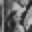

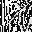

In [17]:
# show the image
train_image = train_image.reshape((32,32))
import PIL.Image
from cStringIO import StringIO
import IPython.display

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

    
showarray(255 * train_image.reshape((32,32)))

diff = train_image - output_image.reshape((32,32))
showarray(255 * diff)

In [16]:
output_image.shape

(1024, 1)

In [19]:
hidden_layers_list= [1,2,3]
hidden_layer_size_list=[4,8,16,32]
dropout_list=[0, 0.333, 0.5]
reg_penalty_list = [0, 0.001]
activation_list = ['relu', 'sigmoid']

epochs = 10
max_epochs = 10000
max_unimproved = 30
batch_size = input_rows

retlist = {}
for hidden_layers in hidden_layers_list:
    for hidden_layer_size in hidden_layer_size_list:
        for dropout in dropout_list:
            for reg_penalty in reg_penalty_list:
                for activation in activation_list:
                    
                    create_model(num_components=input_cols, 
                                 num_hidden_layers=hidden_layers,
                                 hidden_layer_size=hidden_layer_size, 
                                 dropout=dropout, 
                                 reg_penalty=reg_penalty, 
                                 activation=activation)

                    # train until no improvement in loss 
                    best_loss = 999999
                    best_epoch = 0
                    last_epoch = 0
                    for i in range(max_epochs / epochs):
                        fit = model.fit(input_image,
                                        output_image,
                                        epochs=epochs, 
                                        batch_size=input_rows,
                                        verbose=0
                                       )  
                        #get best loss, break if not improved for max_unimproved epochs
                        train_loss_index = np.argmin(fit.history['loss'])
                        train_loss = fit.history['loss'][train_loss_index]
                        if train_loss < best_loss:
                            best_loss = train_loss
                            best_epoch = i * epochs + train_loss_index
                            print("%s Best loss now %f" % (time.strftime("%H:%M:%S"), best_loss))
                        else:
                            epochs_unimproved = (i + 1) * epochs + train_loss_index
                            if epochs_unimproved > max_unimproved:
                                break
                            else:
                                print("%s Best loss still %f after %d epochs" % (time.strftime("%H:%M:%S"), best_loss, epochs_unimproved))

                    train_image = model.predict(input_image)

                    retlist[(hidden_layers, hidden_layer_size, dropout, reg_penalty, activation)] = train_image


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 8         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 13.0
Trainable params: 13
Non-trainable params: 0.0
_________________________________________________________________
None
22:16:27 Best loss now 0.014115
22:16:27 Best loss still 0.014115 after 21 epochs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 8         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 13.0
Trainable params: 13
Non-trainable params: 0.0
_______________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 4)                 8         
_________________________________________________________________
dropout_9 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 5         
Total params: 13.0
Trainable params: 13.0
Non-trainable params: 0.0
_________________________________________________________________
None
22:16:29 Best loss now 0.013676
22:16:29 Best loss still 0.013676 after 20 epochs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_28 (Dense)             (None, 1)               

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 8)                 16        
_________________________________________________________________
dropout_16 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 9         
Total params: 25.0
Trainable params: 25.0
Non-trainable params: 0.0
_________________________________________________________________
None
22:16:32 Best loss now 0.013994
22:16:32 Best loss now 0.013967
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 8)                 16        
_________________________________________________________________
dropout_17 (Dropout)         (None, 8)                 0         
_____

22:16:35 Best loss now 0.014035
22:16:35 Best loss now 0.013949
22:16:35 Best loss now 0.013922
22:16:35 Best loss now 0.013643
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 16)                32        
_________________________________________________________________
dropout_23 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 17        
Total params: 49.0
Trainable params: 49.0
Non-trainable params: 0.0
_________________________________________________________________
None
22:16:35 Best loss now 0.013859
22:16:35 Best loss still 0.013859 after 25 epochs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 16)                32

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 32)                64        
_________________________________________________________________
dropout_30 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 33        
Total params: 97.0
Trainable params: 97.0
Non-trainable params: 0.0
_________________________________________________________________
None
22:16:38 Best loss now 0.013985
22:16:38 Best loss now 0.013732
22:16:38 Best loss still 0.013732 after 30 epochs
22:16:38 Best loss now 0.013286
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 32)                64        
_______________________________________________________

22:16:41 Best loss now 0.013850
22:16:41 Best loss still 0.013850 after 20 epochs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 4)                 8         
_________________________________________________________________
dropout_38 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_118 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_39 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 5         
Total params: 33.0
Trainable params: 33.0
Non-trainable params: 0.0
_________________________________________________________________
None
22:16:42 Best loss now 0.013628
22:16:42 Best loss st

22:16:45 Best loss now 0.013920
22:16:45 Best loss now 0.013827
22:16:45 Best loss now 0.013744
22:16:45 Best loss now 0.013673
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 8)                 16        
_________________________________________________________________
dense_142 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 9         
Total params: 97.0
Trainable params: 97
Non-trainable params: 0.0
_________________________________________________________________
None
22:16:45 Best loss now 0.013820
22:16:45 Best loss still 0.013820 after 21 epochs
22:16:45 Best loss now 0.013770
22:16:45 Best loss now 0.013737
_________________________________________________________________
Layer (type)                 Output Shape              Param 

22:16:48 Best loss now 0.013922
22:16:48 Best loss still 0.013922 after 24 epochs
22:16:48 Best loss now 0.013796
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 8)                 16        
_________________________________________________________________
dropout_62 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_166 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_63 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 9         
Total params: 97.0
Trainable params: 97.0
Non-trainable params: 0.0
_________________________________________________________________
None
22:16:48 Best loss no

22:16:52 Best loss now 0.013738
22:16:52 Best loss now 0.013735
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 16)                32        
_________________________________________________________________
dropout_72 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_193 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_73 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_194 (Dense)            (None, 1)                 17        
Total params: 321.0
Trainable params: 321.0
Non-trainable params: 0.0
_________________________________________________________________
None
22:16:52 Best loss now 0.013692
22:16:52 Best loss still 0.013692 aft

22:16:56 Best loss now 0.013783
22:16:56 Best loss still 0.013783 after 22 epochs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_219 (Dense)            (None, 32)                64        
_________________________________________________________________
dropout_82 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_220 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_83 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_221 (Dense)            (None, 1)                 33        
Total params: 1,153.0
Trainable params: 1,153.0
Non-trainable params: 0.0
_________________________________________________________________
None
22:16:56 Best loss now 0.013712
22:16:56 Best l

22:17:00 Best loss now 0.013769
22:17:00 Best loss now 0.013736
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_243 (Dense)            (None, 4)                 8         
_________________________________________________________________
dense_244 (Dense)            (None, 4)                 20        
_________________________________________________________________
dense_245 (Dense)            (None, 4)                 20        
_________________________________________________________________
dense_246 (Dense)            (None, 1)                 5         
Total params: 53.0
Trainable params: 53
Non-trainable params: 0.0
_________________________________________________________________
None
22:17:00 Best loss now 0.013761
22:17:00 Best loss still 0.013761 after 23 epochs
_________________________________________________________________
Layer (type)                 Output Shape              Pa

22:17:04 Best loss now 0.013928
22:17:04 Best loss now 0.013795
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_275 (Dense)            (None, 4)                 8         
_________________________________________________________________
dropout_110 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_276 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_111 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_277 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_112 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_278 (D

22:17:08 Best loss now 0.013929
22:17:08 Best loss now 0.013892
22:17:09 Best loss now 0.013702
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_307 (Dense)            (None, 8)                 16        
_________________________________________________________________
dropout_122 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_308 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_123 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_309 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_124 (Dropout)        (None, 8)                 0         
______________________________________________

22:17:13 Best loss now 0.013651
22:17:13 Best loss still 0.013651 after 25 epochs
22:17:13 Best loss now 0.013627
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_335 (Dense)            (None, 8)                 16        
_________________________________________________________________
dropout_143 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_336 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_144 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_337 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_145 (Dropout)        (None, 8)                 0         
____________________________

22:17:18 Best loss now 0.013893
22:17:18 Best loss now 0.013842
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_367 (Dense)            (None, 16)                32        
_________________________________________________________________
dropout_155 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_368 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_156 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_369 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_157 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_370 (D

dense_394 (Dense)            (None, 1)                 33        
Total params: 2,209.0
Trainable params: 2,209
Non-trainable params: 0.0
_________________________________________________________________
None
22:17:23 Best loss now 0.013908
22:17:23 Best loss now 0.013682
22:17:23 Best loss now 0.013433
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_395 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_396 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_397 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_398 (Dense)            (None, 1)                 33        
Total params: 2,209.0
Trainable params: 2,209
Non-trainable params: 0.0
_____________________________

22:17:28 Best loss now 0.013653
22:17:28 Best loss now 0.013650
22:17:28 Best loss now 0.013476
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_423 (Dense)            (None, 32)                64        
_________________________________________________________________
dropout_185 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_424 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_186 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_425 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_187 (Dropout)        (None, 32)                0         
______________________________________________

(1, 4, 0, 0, 'relu')


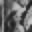

(1, 4, 0, 0, 'sigmoid')


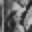

(1, 4, 0, 0.001, 'relu')


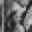

(1, 4, 0, 0.001, 'sigmoid')


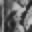

(1, 4, 0.333, 0, 'relu')


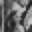

(1, 4, 0.333, 0, 'sigmoid')


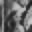

(1, 4, 0.333, 0.001, 'relu')


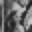

(1, 4, 0.333, 0.001, 'sigmoid')


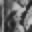

(1, 4, 0.5, 0, 'relu')


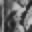

(1, 4, 0.5, 0, 'sigmoid')


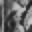

(1, 4, 0.5, 0.001, 'relu')


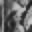

(1, 4, 0.5, 0.001, 'sigmoid')


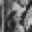

(1, 8, 0, 0, 'relu')


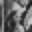

(1, 8, 0, 0, 'sigmoid')


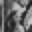

(1, 8, 0, 0.001, 'relu')


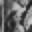

(1, 8, 0, 0.001, 'sigmoid')


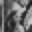

(1, 8, 0.333, 0, 'relu')


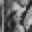

(1, 8, 0.333, 0, 'sigmoid')


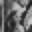

(1, 8, 0.333, 0.001, 'relu')


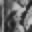

(1, 8, 0.333, 0.001, 'sigmoid')


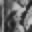

(1, 8, 0.5, 0, 'relu')


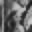

(1, 8, 0.5, 0, 'sigmoid')


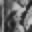

(1, 8, 0.5, 0.001, 'relu')


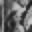

(1, 8, 0.5, 0.001, 'sigmoid')


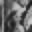

(1, 16, 0, 0, 'relu')


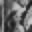

(1, 16, 0, 0, 'sigmoid')


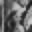

(1, 16, 0, 0.001, 'relu')


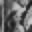

(1, 16, 0, 0.001, 'sigmoid')


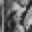

(1, 16, 0.333, 0, 'relu')


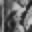

(1, 16, 0.333, 0, 'sigmoid')


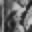

(1, 16, 0.333, 0.001, 'relu')


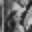

(1, 16, 0.333, 0.001, 'sigmoid')


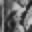

(1, 16, 0.5, 0, 'relu')


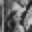

(1, 16, 0.5, 0, 'sigmoid')


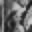

(1, 16, 0.5, 0.001, 'relu')


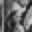

(1, 16, 0.5, 0.001, 'sigmoid')


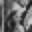

(1, 32, 0, 0, 'relu')


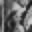

(1, 32, 0, 0, 'sigmoid')


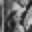

(1, 32, 0, 0.001, 'relu')


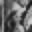

(1, 32, 0, 0.001, 'sigmoid')


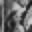

(1, 32, 0.333, 0, 'relu')


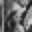

(1, 32, 0.333, 0, 'sigmoid')


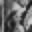

(1, 32, 0.333, 0.001, 'relu')


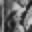

(1, 32, 0.333, 0.001, 'sigmoid')


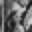

(1, 32, 0.5, 0, 'relu')


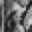

(1, 32, 0.5, 0, 'sigmoid')


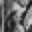

(1, 32, 0.5, 0.001, 'relu')


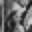

(1, 32, 0.5, 0.001, 'sigmoid')


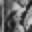

(2, 4, 0, 0, 'relu')


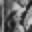

(2, 4, 0, 0, 'sigmoid')


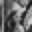

(2, 4, 0, 0.001, 'relu')


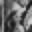

(2, 4, 0, 0.001, 'sigmoid')


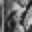

(2, 4, 0.333, 0, 'relu')


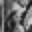

(2, 4, 0.333, 0, 'sigmoid')


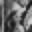

(2, 4, 0.333, 0.001, 'relu')


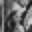

(2, 4, 0.333, 0.001, 'sigmoid')


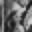

(2, 4, 0.5, 0, 'relu')


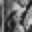

(2, 4, 0.5, 0, 'sigmoid')


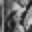

(2, 4, 0.5, 0.001, 'relu')


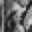

(2, 4, 0.5, 0.001, 'sigmoid')


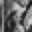

(2, 8, 0, 0, 'relu')


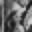

(2, 8, 0, 0, 'sigmoid')


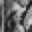

(2, 8, 0, 0.001, 'relu')


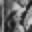

(2, 8, 0, 0.001, 'sigmoid')


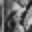

(2, 8, 0.333, 0, 'relu')


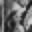

(2, 8, 0.333, 0, 'sigmoid')


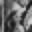

(2, 8, 0.333, 0.001, 'relu')


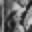

(2, 8, 0.333, 0.001, 'sigmoid')


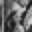

(2, 8, 0.5, 0, 'relu')


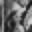

(2, 8, 0.5, 0, 'sigmoid')


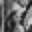

(2, 8, 0.5, 0.001, 'relu')


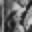

(2, 8, 0.5, 0.001, 'sigmoid')


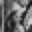

(2, 16, 0, 0, 'relu')


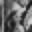

(2, 16, 0, 0, 'sigmoid')


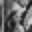

(2, 16, 0, 0.001, 'relu')


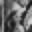

(2, 16, 0, 0.001, 'sigmoid')


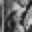

(2, 16, 0.333, 0, 'relu')


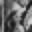

(2, 16, 0.333, 0, 'sigmoid')


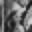

(2, 16, 0.333, 0.001, 'relu')


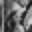

(2, 16, 0.333, 0.001, 'sigmoid')


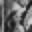

(2, 16, 0.5, 0, 'relu')


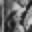

(2, 16, 0.5, 0, 'sigmoid')


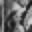

(2, 16, 0.5, 0.001, 'relu')


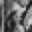

(2, 16, 0.5, 0.001, 'sigmoid')


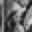

(2, 32, 0, 0, 'relu')


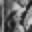

(2, 32, 0, 0, 'sigmoid')


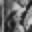

(2, 32, 0, 0.001, 'relu')


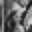

(2, 32, 0, 0.001, 'sigmoid')


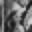

(2, 32, 0.333, 0, 'relu')


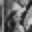

(2, 32, 0.333, 0, 'sigmoid')


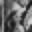

(2, 32, 0.333, 0.001, 'relu')


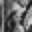

(2, 32, 0.333, 0.001, 'sigmoid')


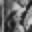

(2, 32, 0.5, 0, 'relu')


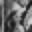

(2, 32, 0.5, 0, 'sigmoid')


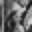

(2, 32, 0.5, 0.001, 'relu')


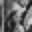

(2, 32, 0.5, 0.001, 'sigmoid')


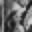

(3, 4, 0, 0, 'relu')


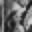

(3, 4, 0, 0, 'sigmoid')


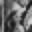

(3, 4, 0, 0.001, 'relu')


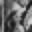

(3, 4, 0, 0.001, 'sigmoid')


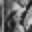

(3, 4, 0.333, 0, 'relu')


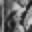

(3, 4, 0.333, 0, 'sigmoid')


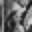

(3, 4, 0.333, 0.001, 'relu')


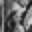

(3, 4, 0.333, 0.001, 'sigmoid')


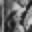

(3, 4, 0.5, 0, 'relu')


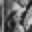

(3, 4, 0.5, 0, 'sigmoid')


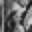

(3, 4, 0.5, 0.001, 'relu')


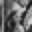

(3, 4, 0.5, 0.001, 'sigmoid')


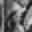

(3, 8, 0, 0, 'relu')


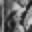

(3, 8, 0, 0, 'sigmoid')


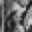

(3, 8, 0, 0.001, 'relu')


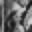

(3, 8, 0, 0.001, 'sigmoid')


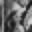

(3, 8, 0.333, 0, 'relu')


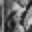

(3, 8, 0.333, 0, 'sigmoid')


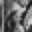

(3, 8, 0.333, 0.001, 'relu')


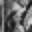

(3, 8, 0.333, 0.001, 'sigmoid')


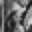

(3, 8, 0.5, 0, 'relu')


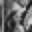

(3, 8, 0.5, 0, 'sigmoid')


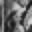

(3, 8, 0.5, 0.001, 'relu')


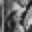

(3, 8, 0.5, 0.001, 'sigmoid')


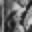

(3, 16, 0, 0, 'relu')


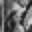

(3, 16, 0, 0, 'sigmoid')


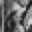

(3, 16, 0, 0.001, 'relu')


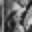

(3, 16, 0, 0.001, 'sigmoid')


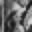

(3, 16, 0.333, 0, 'relu')


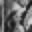

(3, 16, 0.333, 0, 'sigmoid')


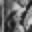

(3, 16, 0.333, 0.001, 'relu')


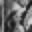

(3, 16, 0.333, 0.001, 'sigmoid')


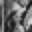

(3, 16, 0.5, 0, 'relu')


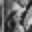

(3, 16, 0.5, 0, 'sigmoid')


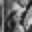

(3, 16, 0.5, 0.001, 'relu')


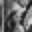

(3, 16, 0.5, 0.001, 'sigmoid')


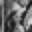

(3, 32, 0, 0, 'relu')


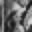

(3, 32, 0, 0, 'sigmoid')


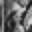

(3, 32, 0, 0.001, 'relu')


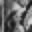

(3, 32, 0, 0.001, 'sigmoid')


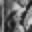

(3, 32, 0.333, 0, 'relu')


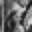

(3, 32, 0.333, 0, 'sigmoid')


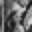

(3, 32, 0.333, 0.001, 'relu')


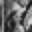

(3, 32, 0.333, 0.001, 'sigmoid')


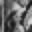

(3, 32, 0.5, 0, 'relu')


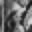

(3, 32, 0.5, 0, 'sigmoid')


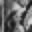

(3, 32, 0.5, 0.001, 'relu')


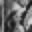

(3, 32, 0.5, 0.001, 'sigmoid')


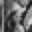

In [20]:
# show images
prev_image = None
for hidden_layers in hidden_layers_list:
    for hidden_layer_size in hidden_layer_size_list:
        for dropout in dropout_list:
            for reg_penalty in reg_penalty_list:
                for activation in activation_list:
                    image = retlist[(hidden_layers, hidden_layer_size, dropout, reg_penalty, activation)]
                    if prev_image is None:
                        prev_image = image
                    print (hidden_layers, hidden_layer_size, dropout, reg_penalty, activation)
#                    diff = image - output_image
#                    diff = image - prev_image
#                    showarray(255 * diff.reshape((32,32)))
                    showarray(255 * image.reshape((32,32)))
                    prev_image = image
    
                    


In [21]:
# for amusement let's try building some autoencoders
# https://blog.keras.io/building-autoencoders-in-keras.html

from keras.models import Model
encoding_dim = 32  # 784 floats -> 32 floats -> compression factor 24.5:1
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
# (the model we're going to train end-to-end)
autoencoder = Model(input_img, decoded)

# this model maps an input to its intermediate representation 
# (extract model from 1st 2 layers, which compresses)
encoder = Model(input_img, encoded)

# this model maps the compressed version to the uncompressed version
# (extract model from last layer, which uncompresses)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

#
#TODO
#add a function to create the model with variable compression, number of layers, regularization


In [22]:
# train the model on MNIST
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s - loss: 0.3777 - val_loss: 0.2730
Epoch 2/50
60000/60000 [==============================] - 3s - loss: 0.2660 - val_loss: 0.2557
Epoch 3/50
60000/60000 [==============================] - 3s - loss: 0.2448 - val_loss: 0.2314
Epoch 4/50
60000/60000 [==============================] - 3s - loss: 0.2227 - val_loss: 0.2124
Epoch 5/50
60000/60000 [==============================] - 3s - loss: 0.2069 - val_loss: 0.1993
Epoch 6/50
60000/60000 [==============================] - 3s - loss: 0.1959 - val_loss: 0.1898
Epoch 7/50
60000/60000 [==============================] - 3s - loss: 0.1876 - val_loss: 0.1825
Epoch 8/50
60000/60000 [==============================] - 3s - loss: 0.1807 - val_loss: 0.1761
Epoch 9/50
60000/60000 [==============================] - 3s - loss: 0.1746 - val_loss: 0.1706
Epoch 10/50
60000/60000 [==============================] - 3s - loss:

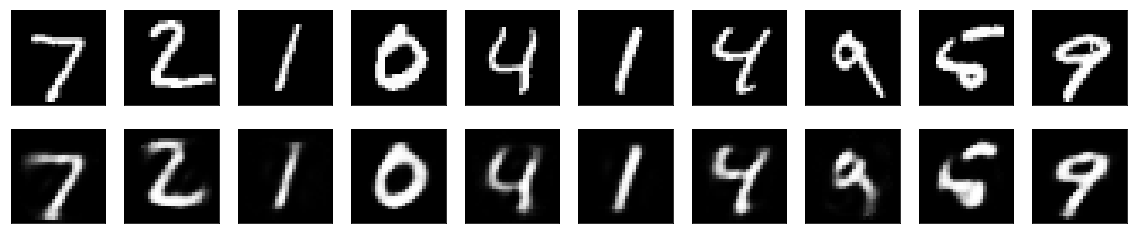

In [23]:
# show some test images

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
